In [1]:
import re
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import tokenize
from nltk.probability import FreqDist 
from nltk.stem import WordNetLemmatizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
file_tsv = 'data/train.tsv'
data = pd.read_csv(file_tsv, sep='\t')
data

,text,label
0,RT @USER: when you in a public place and ya si...,NG
1,@USER he ate my pussy i could..,NG
2,"When you give somebody that ""bitch"" look",NG
3,Double Stuff Oreos mane say,OK
4,@USER lol la bitch happy bout Beatin our bench...,NG
...,...,...
18677,RT @USER: @USER @USER @USER @USER fuck no id b...,NG
18678,"""@USER: ""@USER: ""@USER: ""@USER: @USER swears I...",OK
18679,Its wayyyyy more going on now than 2 have u pu...,NG
18680,"Mum agrees with me, ur being a wee moody cunt ...",NG


# DATA EXPLORATION

In [3]:
train_data = data.copy()

In [4]:
train_pivot = train_data.groupby('label').agg({'label':'count'})
train_pivot

,label
label,
NG,15352
OK,3330


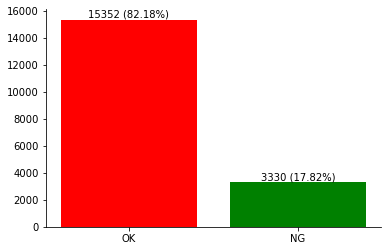

In [5]:
bars = plt.bar(range(2), train_pivot.label,color=['r', 'g'])
plt.xticks([0,1])
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width() / 2, h,str(h)+' (%.2f%%)' % (h/len(train_data)*100) , ha='center', va='bottom')
ax = plt.gca()
ax.set_xticklabels({"OK", 'NG'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# FEATURE ENGINEERING

Extract the most important information from the data by removing contractions, punctuation, emojis and stopwords from the post and lemmatizing the words

In [6]:
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/irma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/irma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
punctuation = string.punctuation
punctuation = punctuation + '—' + '“' + '”'
punctuation_without_exclamation = punctuation.replace('!', '')
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—“”'

In [8]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"im":"I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"'s'" : " is"
}

In [9]:
def text_processing(post):
    
    #Expand contractions in the post
    contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
    def expand_contractions(s, contractions_dict=contractions):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, s)
    
    no_contractions_post = expand_contractions(post)
          
    #Remove punctuation from the post
    def remove_punctuation(post):
        return post.translate(str.maketrans('', '', punctuation))
        
    no_punctuation_post = remove_punctuation(no_contractions_post)
    
    #Remove emojis from the post
    def remove_emoji(post):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', post)
    
    no_emoji_post = remove_emoji(no_punctuation_post)
    

    #Remove stopwords from the post
    def remove_stopwords(post):
        not_important = ['RT', 'USER', 'URL']
        post = post.replace("RT", '')
        post_list = [word for word in post.split() if word not in not_important]
        no_stopwords_list = [word.lower() for word in post_list if word.lower() not in stop]
        return no_stopwords_list
    
    no_stopwords_post = remove_stopwords(no_emoji_post)
    
    #Lemmatize the words in post
    def lemmatize_post(post):
        lem = WordNetLemmatizer()
        lemmatized_post = []
        for word in post:
            lemmatized_text = lem.lemmatize(word,'v')
            lemmatized_post.append(lemmatized_text)
        return lemmatized_post
    
    return lemmatize_post(no_stopwords_post)

In [10]:
train_data['processed_text'] = train_data['text'].apply(text_processing)
train_data['exclamation_count'] = train_data['text'].apply(lambda x: x.count('!'))
train_data

,text,label,processed_text,exclamation_count
0,RT @USER: when you in a public place and ya si...,NG,"[public, place, ya, side, hoe, come, outta]",0
1,@USER he ate my pussy i could..,NG,"[eat, pussy, could]",0
2,"When you give somebody that ""bitch"" look",NG,"[give, somebody, bitch, look]",0
3,Double Stuff Oreos mane say,OK,"[double, stuff, oreos, mane, say]",0
4,@USER lol la bitch happy bout Beatin our bench...,NG,"[lol, la, bitch, happy, bout, beatin, bench, p...",0
...,...,...,...,...
18677,RT @USER: @USER @USER @USER @USER fuck no id b...,NG,"[fuck, id, gettin, swole, like, everyday, nigger]",0
18678,"""@USER: ""@USER: ""@USER: ""@USER: @USER swears I...",OK,"[swear, 1, man, easily, easily, behind, austin...",0
18679,Its wayyyyy more going on now than 2 have u pu...,NG,"[wayyyyy, go, 2, u, push, yo, trash, ass, musi...",0
18680,"Mum agrees with me, ur being a wee moody cunt ...",NG,"[mum, agree, ur, wee, moody, cunt, cani, deal,...",0


In [11]:
# Print top 20 most frequent words in text
def top_20(text):
    freq = FreqDist()
    for sentence in nltk.tokenize.sent_tokenize(text):
        for word in nltk.tokenize.word_tokenize(sentence):
            freq[word] += 1
    most_freq = freq.most_common(20)
    words = [w[0] for w in most_freq]
    num = [n[1] for n in most_freq]
    plt.barh(words,num,alpha=0.8)

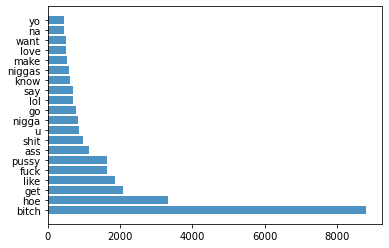

In [12]:
words = []
for phrase in train_data[train_data['label'] == 'NG']['processed_text']:
    for word in phrase:
        words.append(word)
text_ng = ' '.join(words)
top_20(text_ng)

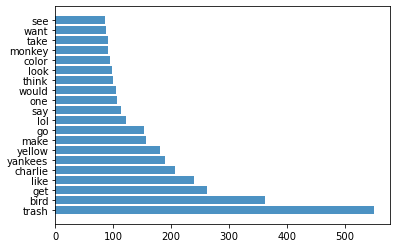

In [13]:
words = []
for phrase in train_data[train_data['label'] == 'OK']['processed_text']:
    for word in phrase:
        words.append(word)
text_ok = ' '.join(words)
top_20(text_ok)

# DATA MODELLING

 For a text classification/sentiment analysis I am using differnt classification models: Naive Bayes, Random Forest Classifier, Support Vector Classification, 
 Linear Support Vector Classifier, Gradient Boosting Classifier. The main comparison criteria are accuracy score, f1-score and training time. 

In [14]:
post_train, post_test, label_train, label_test = train_test_split(train_data['text'], train_data['label'], test_size=0.2)

## Naive Bayes with CountVectorizer

In [15]:
#Machine Learning Pipeline with Naive Bayes and CountVectorizer
pipeline_bayes_count = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors with Naive Bayes 
])
time_bayes = %timeit -n1 -r1 -o pipeline_bayes_count.fit(post_train,label_train)
print("{:.2f}".format(time_bayes.average))

1.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.95


In [16]:
%time predictions = pipeline_bayes_count.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 502 ms, sys: 75 µs, total: 502 ms
Wall time: 503 ms
              precision    recall  f1-score   support

          NG       0.99      0.92      0.95      3311
          OK       0.59      0.93      0.72       426

    accuracy                           0.92      3737
   macro avg       0.79      0.92      0.84      3737
weighted avg       0.94      0.92      0.93      3737



[[3042  269]
 [  31  395]]
0.9197217018999198


## Naive Bayes with TfidfVectorizer

In [17]:
#Machine Learning Pipeline with Naive Bayes and TfidfVectorizer
pipeline_bayes_tfidf = Pipeline([
    ('bow',TfidfVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors with Naive Bayes 
])
time_bayes = %timeit -n1 -r1 -o pipeline_bayes_tfidf.fit(post_train,label_train)
print("{:.2f}".format(time_bayes.average))

1.88 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.88


In [18]:
%time predictions = pipeline_bayes_tfidf.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 481 ms, sys: 4.15 ms, total: 485 ms
Wall time: 493 ms
              precision    recall  f1-score   support

          NG       1.00      0.84      0.92      3632
          OK       0.15      0.95      0.26       105

    accuracy                           0.85      3737
   macro avg       0.57      0.90      0.59      3737
weighted avg       0.97      0.85      0.90      3737



[[3068  564]
 [   5  100]]
0.8477388279368477


## Random Forest Classifier

In [19]:
#Machine Learning Pipeline with Random Forest Classifier
pipeline_forest = Pipeline([
    ('bow',TfidfVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors with Random Forest Classifier
])
time_forest = %timeit -n1 -r1 -o pipeline_forest.fit(post_train,label_train)
print("{:.2f}".format(time_forest.average))

8.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.54


In [20]:
%time predictions = pipeline_forest.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 746 ms, sys: 3.89 ms, total: 750 ms
Wall time: 756 ms
              precision    recall  f1-score   support

          NG       0.98      0.95      0.97      3181
          OK       0.77      0.92      0.83       556

    accuracy                           0.95      3737
   macro avg       0.88      0.93      0.90      3737
weighted avg       0.95      0.95      0.95      3737



[[3026  155]
 [  47  509]]
0.9459459459459459


## Support Vector Classification

In [21]:
#Machine Learning Pipeline with Support Vector Classification
pipeline_svm = Pipeline([
    ('bow',TfidfVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', svm.SVC(random_state=42)), # train on TF-IDF vectors with Support Vector Classification
]) 
time_svm = %timeit -n1 -r1 -o pipeline_svm.fit(post_train,label_train)
print("{:.2f}".format(time_svm.average))

25.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
25.21


In [22]:
%time predictions = pipeline_svm.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 2.3 s, sys: 16.1 ms, total: 2.32 s
Wall time: 2.33 s
              precision    recall  f1-score   support

          NG       0.98      0.97      0.97      3104
          OK       0.84      0.89      0.87       633

    accuracy                           0.95      3737
   macro avg       0.91      0.93      0.92      3737
weighted avg       0.95      0.95      0.95      3737



[[3001  103]
 [  72  561]]
0.9531709927749532


## Linear Support Vector Classification

In [23]:
#Machine Learning Pipeline with Linear Support Vector Classification
pipeline_lin_svm = Pipeline([
    ('bow',TfidfVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', svm.LinearSVC(random_state=42)), # train on TF-IDF vectors with Linear Support Vector Classification
])
time_lin_svm = %timeit -n1 -r1 -o pipeline_lin_svm.fit(post_train,label_train)
print("{:.2f}".format(time_lin_svm.average))

1.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.93


In [24]:
%time predictions = pipeline_lin_svm.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 494 ms, sys: 3.97 ms, total: 498 ms
Wall time: 498 ms
              precision    recall  f1-score   support

          NG       0.97      0.98      0.97      3068
          OK       0.89      0.88      0.88       669

    accuracy                           0.96      3737
   macro avg       0.93      0.93      0.93      3737
weighted avg       0.96      0.96      0.96      3737



[[2992   76]
 [  81  588]]
0.957987690660958


## Gradient Boosting Classifier

In [25]:
#Machine Learning Pipeline with Gradient Boosting Classifier
pipeline_gradient = Pipeline([
    ('bow',TfidfVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('classifier', GradientBoostingClassifier()), # train on TF-IDF vectors with Linear Support Vector Machine
])
time_gradient = %timeit -n1 -r1 -o pipeline_gradient.fit(post_train,label_train)
print("{:.2f}".format(time_gradient.average))

5.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.78


In [26]:
%time predictions = pipeline_gradient.predict(post_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

CPU times: user 488 ms, sys: 31.9 ms, total: 520 ms
Wall time: 520 ms
              precision    recall  f1-score   support

          NG       0.98      0.92      0.95      3271
          OK       0.61      0.88      0.72       466

    accuracy                           0.92      3737
   macro avg       0.80      0.90      0.84      3737
weighted avg       0.94      0.92      0.92      3737



[[3015  256]
 [  58  408]]
0.915975381321916


All classifiers except for Naive Bayes with TfidfVectorizer show an accuracy score of more than 91%. The highest accuracy score is around 95%.
F1-score for both classes is almost equal for Random Forest Classifier, Support Vector Classification, Linear Support Vector Classification, Gradient Boosting Classifier. Around 95-97% for 'NG'-class and 85-87% for 'OK'-class.

Best training time (2 sec) is obtained with Naive Bayes and Linear Support Vector Classification. But Naive Bayes delivers clearly worse results than the Linear Support Vector Classification.
Worst time is more than 20 sec (with Support Vector Classification)

Naive Bayes has a significant difference in result depending on Vectorizer type. TfidfVectorizer worsens the f1-score for 'OK'-class from ~74% to ~30% and accuracy score from 91.9% to 84.7% compared to CountVectorizer. It may be due to the classes imbalance. For the other classification models the Vectorizer type is irrelevant.

My reccomendation is to choose the Linear Support Vector Classification as it offers the best performance - the shortest time and the highest accuracy.

# PREDICTION ON UNLABELED DATA 
# WITH LINEAR SUPPORT VECTOR CLASSIFICATION

In [27]:
file_tsv = 'data/test.tsv.dist'
test_data= pd.read_csv(file_tsv, sep='\t')
test_data

,text,label
0,Niggas cry when they get hit high and cry when...,?
1,RT @USER: Boss Niggas Fuk wit Boss bitches Vic...,?
2,"Notice I didn't tweet ""bytches"".... Bytch is d...",?
3,@USER @USER fuck up pussy,?
4,@USER i swear u a fuck nigga u a scary little ...,?
...,...,...
4666,“@USER: Malibus on a come-up but in other news...,?
4667,Hate when bitches get boyfriends then forget a...,?
4668,#ExplainAnAnimePlotBadly Boy with a monkey tai...,?
4669,Crying to the G20 that some Americans don't li...,?


In [28]:
post_train, label_train, post_test = train_data['text'], train_data['label'], test_data['text']

In [29]:
pipeline_lin_svm.fit(post_train,label_train)

Pipeline(steps=[('bow',
                 TfidfVectorizer(analyzer=<function text_processing at 0x7f0681cb90d0>)),
                ('classifier', LinearSVC(random_state=42))])

In [30]:
test_data['label_lin_svm'] = pipeline_lin_svm.predict(post_test)
test_data = test_data.drop('label', 1)
test_data

,text,label_lin_svm
0,Niggas cry when they get hit high and cry when...,NG
1,RT @USER: Boss Niggas Fuk wit Boss bitches Vic...,NG
2,"Notice I didn't tweet ""bytches"".... Bytch is d...",NG
3,@USER @USER fuck up pussy,NG
4,@USER i swear u a fuck nigga u a scary little ...,NG
...,...,...
4666,“@USER: Malibus on a come-up but in other news...,NG
4667,Hate when bitches get boyfriends then forget a...,NG
4668,#ExplainAnAnimePlotBadly Boy with a monkey tai...,OK
4669,Crying to the G20 that some Americans don't li...,NG


In [33]:
test_data.to_csv('data/test_labeled.tsv.dist', index=False, sep='\t')